# Load Data

In [6]:
import tensorflow as tf

# Load the Fashion MNIST dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the data
x_train, x_test = x_train / 255.0, x_test / 255.0

### Data Prep

In [7]:
import numpy as np

train_filter = (y_train == 3) | (y_train == 5) | (y_train == 8)
x_train_nn = x_train[train_filter]
y_train_nn = y_train[train_filter]

test_filter = (y_test == 3) | (y_test == 5) | (y_test == 8)
x_test_nn = x_test[test_filter]
y_test_nn = y_test[test_filter]

# Convert to categorical labels:
# 3 -> 0, 5 -> 1, 8 -> 2
y_train_nn_bin = ((y_train_nn == 5).astype(int) + 2 * (y_train_nn == 8).astype(int))
y_test_nn_bin = ((y_test_nn == 5).astype(int) + 2 * (y_test_nn == 8).astype(int))

print("Unique values in training labels:", np.unique(y_train_nn_bin))
print("Label distribution in training set:", np.bincount(y_train_nn_bin))



Unique values in training labels: [0 1 2]
Label distribution in training set: [6131 5421 5851]


### Plot Data

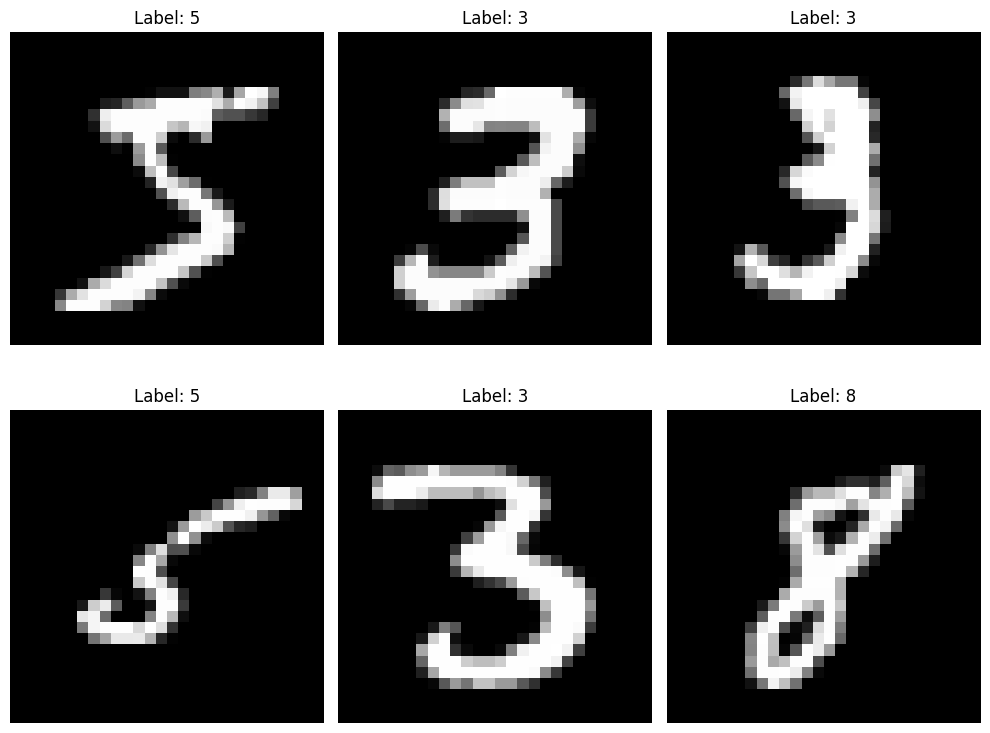

In [8]:
## Plot 6 to 10 images from your data

'Your code here'
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(10, 8))
for i, ax in enumerate(axes.flat):
    if i < 6:
        ax.imshow(x_train_nn[i], cmap='gray')
        ax.set_title(f'Label: {y_train_nn[i]}')
        ax.axis('off')
plt.tight_layout()
plt.show()

# CNN with Pytorth

### Design the CNN Model

In [9]:
# Define the CNN model
import torch
from torch.utils.data import DataLoader, TensorDataset

import torch.nn as nn
import torch.optim as optim
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x.to('cuda' if torch.cuda.is_available() else 'cpu')


### Data Prep

In [10]:
# Convert the data to PyTorch tensors
x_train_tensor = torch.tensor(x_train_nn.reshape(-1, 1, 28, 28), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_nn_bin, dtype=torch.long)
x_test_tensor = torch.tensor(x_test_nn.reshape(-1, 1, 28, 28), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_nn_bin, dtype=torch.long)

# Create DataLoader for training and testing
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Fit the CNN

In [11]:
# Initialize the model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
t_model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(t_model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    t_model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = t_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Calculate validation loss and accuracy
    t_model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for val_inputs, val_labels in test_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
            
            val_outputs = t_model(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()
            _, predicted = torch.max(val_outputs, 1)
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()
    
    # Compute metrics
    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(test_loader)
    val_accuracy = correct / total
    
    # Print metrics rounded to 4 decimals
    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Train Loss: {avg_train_loss:.4f}, '
          f'Validation Loss: {avg_val_loss:.4f}, '
          f'Validation Accuracy: {val_accuracy:.4f}')


Epoch 1/10, Train Loss: 0.1355, Validation Loss: 0.0536, Validation Accuracy: 0.9795
Epoch 2/10, Train Loss: 0.0305, Validation Loss: 0.0179, Validation Accuracy: 0.9941
Epoch 3/10, Train Loss: 0.0192, Validation Loss: 0.0145, Validation Accuracy: 0.9944
Epoch 4/10, Train Loss: 0.0144, Validation Loss: 0.0144, Validation Accuracy: 0.9951
Epoch 5/10, Train Loss: 0.0120, Validation Loss: 0.0172, Validation Accuracy: 0.9937
Epoch 6/10, Train Loss: 0.0090, Validation Loss: 0.0150, Validation Accuracy: 0.9944
Epoch 7/10, Train Loss: 0.0072, Validation Loss: 0.0142, Validation Accuracy: 0.9958
Epoch 8/10, Train Loss: 0.0041, Validation Loss: 0.0177, Validation Accuracy: 0.9941
Epoch 9/10, Train Loss: 0.0046, Validation Loss: 0.0145, Validation Accuracy: 0.9955
Epoch 10/10, Train Loss: 0.0037, Validation Loss: 0.0169, Validation Accuracy: 0.9944


### Plot Confusion Matrix

[[999   8   3]
 [  4 887   1]
 [  0   0 974]]


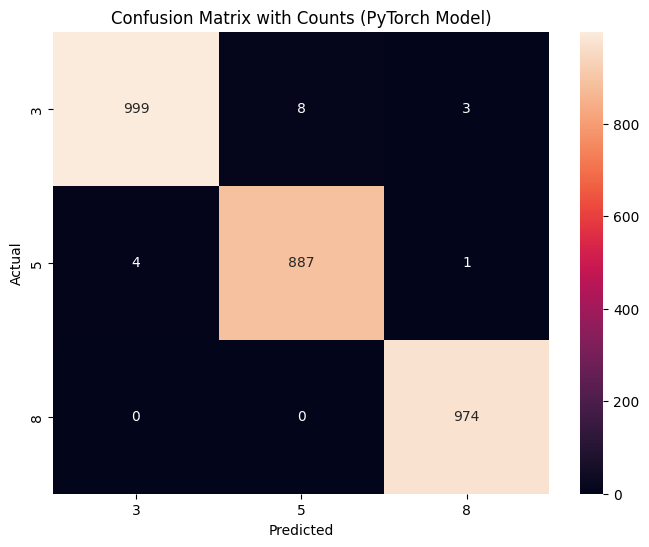

In [12]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make predictions on the test set
t_model.eval()
test_predictions = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)  # Move inputs to the same device as the model
        outputs = t_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_predictions.extend(predicted.cpu().numpy())  # Move predictions back to CPU before converting to numpy

# Convert predictions to numpy array
test_predictions = np.array(test_predictions)

# Compute the confusion matrix
conf_matrix_torch = confusion_matrix(y_test_nn_bin, test_predictions)

# Print the confusion matrix
print(conf_matrix_torch)

# Plot the confusion matrix with counts
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_torch, annot=True, fmt='d', xticklabels=[3,5,8], yticklabels=[3,5,8])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Counts (PyTorch Model)')
plt.show()

### Plot Misclassifications

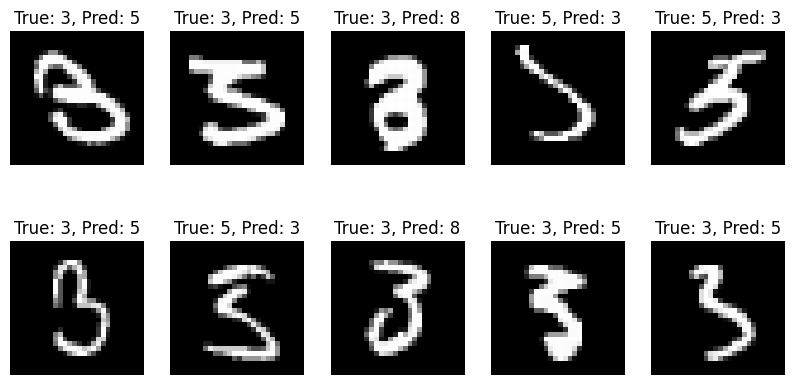

In [13]:
# Create a mapping dictionary for label conversion
label_map = {0: 3, 1: 5, 2: 8}

# Find the indices of misclassified samples
misclassified_indices_torch = [i for i in range(len(y_test_nn_bin)) if test_predictions[i] != y_test_nn_bin[i]]

plt.figure(figsize=(10, 5))

for i, idx in enumerate(misclassified_indices_torch[:10]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test_nn[idx], cmap='gray')
    true_label = label_map[y_test_nn_bin[idx]]
    pred_label = label_map[test_predictions[idx]]
    plt.title(f'True: {true_label}, Pred: {pred_label}')
    plt.axis('off')

plt.show()

# CNN with Transformations

### Data Transformations

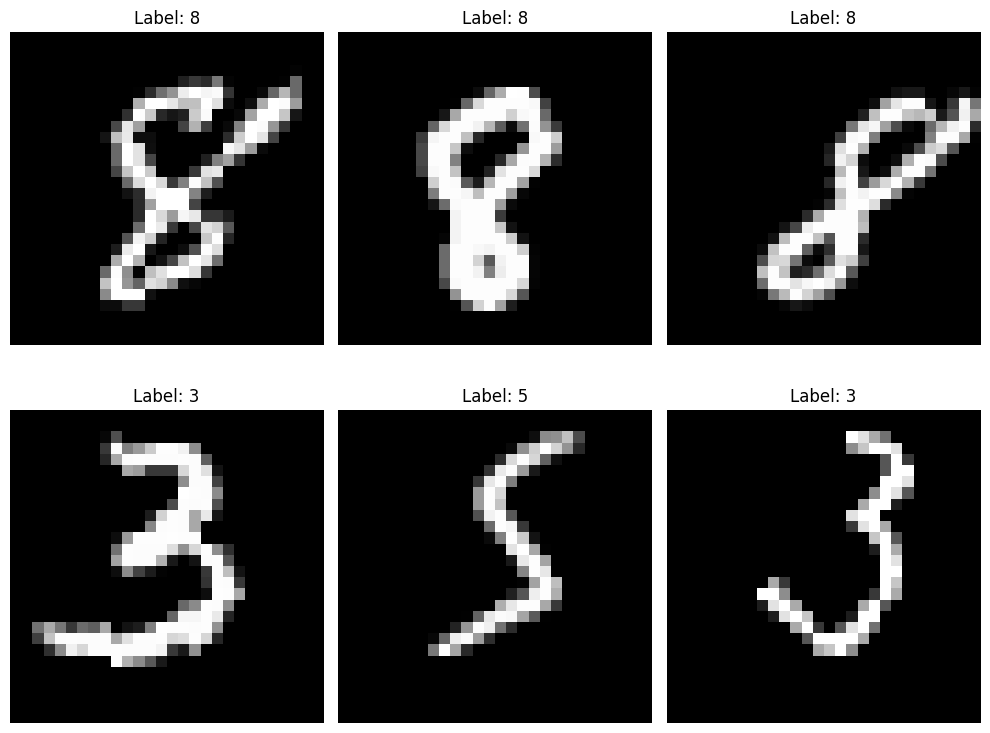

In [14]:
from torchvision.datasets import MNIST

import torchvision.transforms as transforms

# Define test transformation (no augmentation for test data)
test_mod = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Define data augmentation transformations for training
train_mod = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Define label mapping function for 3,5,8
def map_labels(target):
    if isinstance(target, torch.Tensor):
        return ((target == 5).long() + 2 * (target == 8).long())
    return ((target == 5).astype(int) + 2 * (target == 8).astype(int))

# Custom dataset class to handle label mapping
class FilteredMNIST(MNIST):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=True):
        super().__init__(root, train, transform, target_transform, download)
        # Filter for digits 3, 5, and 8
        mask = (self.targets == 3) | (self.targets == 5) | (self.targets == 8)
        self.data = self.data[mask]
        self.targets = self.targets[mask]
        # Map labels: 3->0, 5->1, 8->2
        self.targets = map_labels(self.targets)

# Create datasets
train_dataset = FilteredMNIST(root="./data", train=True, transform=train_mod, download=True)
test_dataset = FilteredMNIST(root="./data", train=False, transform=test_mod, download=True)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Plot some transformed training images
plt.figure(figsize=(10, 8))
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Create label map for display
label_map = {0: 3, 1: 5, 2: 8}

for i in range(6):
    plt.subplot(2, 3, i + 1)
    img = images[i].squeeze().numpy()
    plt.imshow(img, cmap='gray')
    plt.title(f'Label: {label_map[labels[i].item()]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

### Fit the CNN

In [16]:
# Initialize the model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
t_model_aug = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(t_model_aug.parameters(), lr=0.001)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    t_model_aug.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = t_model_aug(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Calculate validation loss and accuracy
    t_model_aug.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for val_inputs, val_labels in test_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
            
            val_outputs = t_model_aug(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()
            _, predicted = torch.max(val_outputs, 1)
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()
    
    # Compute metrics
    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(test_loader)
    val_accuracy = correct / total
    
    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Train Loss: {avg_train_loss:.4f}, '
          f'Validation Loss: {avg_val_loss:.4f}, '
          f'Validation Accuracy: {val_accuracy:.4f}')

# this one actually seems to do slightly better than the first one, if not the same

Epoch 1/10, Train Loss: 0.2185, Validation Loss: 0.0185, Validation Accuracy: 0.9944
Epoch 2/10, Train Loss: 0.0696, Validation Loss: 0.0186, Validation Accuracy: 0.9934
Epoch 3/10, Train Loss: 0.0504, Validation Loss: 0.0131, Validation Accuracy: 0.9955
Epoch 4/10, Train Loss: 0.0394, Validation Loss: 0.0131, Validation Accuracy: 0.9948
Epoch 5/10, Train Loss: 0.0372, Validation Loss: 0.0183, Validation Accuracy: 0.9934
Epoch 6/10, Train Loss: 0.0309, Validation Loss: 0.0179, Validation Accuracy: 0.9920
Epoch 7/10, Train Loss: 0.0264, Validation Loss: 0.0133, Validation Accuracy: 0.9948
Epoch 8/10, Train Loss: 0.0249, Validation Loss: 0.0126, Validation Accuracy: 0.9955
Epoch 9/10, Train Loss: 0.0247, Validation Loss: 0.0115, Validation Accuracy: 0.9951
Epoch 10/10, Train Loss: 0.0238, Validation Loss: 0.0104, Validation Accuracy: 0.9958
